In [1]:
import torch
import numpy as np
from kan import *

In [2]:
def B_batch(x, grid, k=0):
    '''
    evaludate x on B-spline bases

    Args:
    -----
        x : 2D torch.tensor
            inputs, shape (number of splines, number of samples)
        grid : 2D torch.tensor
            grids, shape (number of splines, number of grid points)
        k : int
            the piecewise polynomial order of splines.

    Returns:
    --------
        spline values : 3D torch.tensor
            shape (number of splines, number of B-spline bases (coeffcients), number of samples). The numbef of B-spline bases = number of grid points + k - 1.

    Example
    -------
    >>> num_spline = 5
    >>> num_sample = 100
    >>> num_grid_interval = 10
    >>> k = 3
    >>> x = torch.normal(0,1,size=(num_spline, num_sample))
    >>> grids = torch.einsum('i,j->ij', torch.ones(num_spline,), torch.linspace(-1,1,steps=num_grid_interval+1))
    >>> B_batch(x, grids, k=k).shape
    torch.Size([5, 13, 100])
    '''

    grid = grid.unsqueeze(dim=2)
    x = x.unsqueeze(dim=1)

    if k == 0:
        value = (x >= grid[:, :-1]) * (x < grid[:, 1:])
    else:
        B_km1 = B_batch(x[:, 0], grid=grid[:, :, 0], k=k - 1)
        value = (x - grid[:, :-(k + 1)]) / (grid[:, k:-1] - grid[:, :-(k + 1)]) * B_km1[:, :-1] + (
                    grid[:, k + 1:] - x) / (grid[:, k + 1:] - grid[:, 1:(-k)]) * B_km1[:, 1:]
    return value

In [4]:
def gen_grid(in_features, spline_order, grid_size, grid_range=[-1, 1]):
    h = (grid_range[1] - grid_range[0]) / grid_size
    grid = (
        (
            torch.arange(-spline_order, grid_size + spline_order + 1) * h
            + grid_range[0]
        )
        .expand(in_features, -1)
        .contiguous()
    )
    return grid

def b_splines(grid: torch.Tensor, x: torch.Tensor, spline_order: int):
    """
    Compute the B-spline bases for the given input tensor.

    Args:
        grid (torch.Tensor): Grid tensor of shape (in_features, grid_size + 2 * spline_order + 1).
        x (torch.Tensor): Input tensor of shape (batch_size, in_features).
        spline_order (int): Spline order.

    Returns:
        torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
    """

    x = x.unsqueeze(-1)
    bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
    for k in range(1, spline_order + 1):
        bases = (
            (x - grid[:, : -(k + 1)])
            / (grid[:, k:-1] - grid[:, : -(k + 1)])
            * bases[:, :, :-1]
        ) + (
            (grid[:, k + 1 :] - x)
            / (grid[:, k + 1 :] - grid[:, 1:(-k)])
            * bases[:, :, 1:]
        )
    return bases.contiguous()

def b_splines_einsum(grid: torch.Tensor, x: torch.Tensor, spline_order: int):
    """
    Compute the B-spline bases for the given input tensor.

    Args:
        grid (torch.Tensor): Grid tensor of shape (in_features, grid_size + 2 * spline_order + 1).
        x (torch.Tensor): Input tensor of shape (batch_size, in_features).
        spline_order (int): Spline order.

    Returns:
        torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
    """

    x_u = x.unsqueeze(-1)
    bases = ((x_u >= grid[:, :-1]) & (x_u < grid[:, 1:])).to(x.dtype)
    return bases
    for k in range(1, spline_order + 1):
        print(x.shape)
        print(bases.shape)
        print(grid.shape)
        bases = (
            (x - grid[:, : -(k + 1)])
            / (grid[:, k:-1] - grid[:, : -(k + 1)])
            * bases[:, :, :-1]
        ) + (
            (grid[:, k + 1 :] - x)
            / (grid[:, k + 1 :] - grid[:, 1:(-k)])
            * bases[:, :, 1:]
        )
    return bases.contiguous()

In [4]:
gen_grid(1, 3, 2)

tensor([[-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.]])

In [5]:
in_features = 2
out_features = 3
spline_order = 3
grid_size = 5
batch_size = 41

grid = gen_grid(in_features, spline_order, grid_size)
grid_expand = grid.repeat_interleave(out_features, dim=0)

x = torch.linspace(-3, 3, batch_size)
x = torch.stack([x, -x]).transpose(0, 1)
x.requires_grad = True
x_expand = x.detach().clone().repeat_interleave(out_features, dim=1).transpose(0, 1)
x_expand.requires_grad = True

bases = b_splines(grid, x, spline_order)
bases_extend = B_batch(x_expand, grid_expand, spline_order)
torch.allclose(bases.repeat_interleave(out_features, dim=1).permute(1, 2, 0), bases_extend)

True

In [6]:
coefficients = torch.randn(out_features, in_features, grid_size + spline_order, requires_grad=True)
weights = torch.randn(out_features, in_features * out_features, requires_grad=True)
biases = torch.randn(out_features, requires_grad=True)
# i: num_samples
# j: in_features
# k: num_bases
# a: out_features
splines = torch.einsum('ijk,ajk->iaj', bases, coefficients)
coeff_ex = coefficients.detach().clone().permute(1, 0, 2).reshape(in_features * out_features, -1)
splines_ex = torch.einsum('ij,ijk->ik', coeff_ex, bases_extend)
# splines = (bases.unsqueeze(1) * coefficients.unsqueeze(0)).sum(dim=-1)
activation = splines.reshape(-1, in_features * out_features) @ weights.T + biases
# activation

In [9]:
activation.shape

torch.Size([41, 3])

In [7]:
A = splines_ex.transpose(0, 1).reshape(-1, in_features, out_features).transpose(1, 2)
torch.allclose(A, splines)

True

In [8]:
x.grad = None
coefficients.grad = None
splines.sum().backward(retain_graph=True)

In [9]:
x_expand.grad = None
A.sum().backward(retain_graph=True)

In [10]:
def spline_der(x, coeff, grid, spline_order):
    bases = b_splines(grid, x, spline_order - 1)
    numerator = coeff[:, :, 1:] - coeff[:, :, :-1]
    denominator = grid[:, (spline_order + 1):-1] - grid[:, 1:-(spline_order + 1)]
    frac = numerator / denominator
    print(numerator.shape)
    print(denominator.shape)
    print(frac.shape)
    print(bases[:, :, 1:-1].shape)
    return (frac.unsqueeze(0) * bases[:, :, 1:-1].unsqueeze(1)).sum(dim=-1).sum(dim=1) * spline_order

def spline_der_full(x, coeff, grid, spline_order):
    bases = b_splines(grid, x, spline_order - 1)
    den1 = grid[:, spline_order:-1] - grid[:, :-(spline_order + 1)]
    den2 = grid[:, (spline_order + 1):] - grid[:, 1:-spline_order]
    print(den1.shape)
    print(den2.shape)
    print(bases[:, :, :-1].shape)
    tmp = bases[:, :, :-1] / den1.unsqueeze(0) - bases[:, :, 1:] / den2.unsqueeze(0)
    print(tmp.shape)
    print(coeff.shape)
    return (coefficients.unsqueeze(0) * tmp.unsqueeze(1)).sum(dim=-1).sum(dim=1) * spline_order

def spline_der_residuals(x, coeff, grid, spline_order):
    bases = b_splines(grid, x, spline_order - 1)
    return bases
    numerator = coeff[:, :, 1:] - coeff[:, :, :-1]
    denominator = grid[:, (spline_order + 1):-1] - grid[:, 1:-(spline_order + 1)]
    frac = numerator / denominator
    print(numerator.shape)
    print(denominator.shape)
    print(frac.shape)
    print(bases[:, :, 1:-1].shape)
    return (frac.unsqueeze(0) * bases[:, :, 1:-1].unsqueeze(1)).sum(dim=-1).sum(dim=1) * spline_order

def spline_der_1(x, coeff, grid, spline_order, i, j, k):
    bases = b_splines(grid, x, spline_order - 1)
    numerator = coeff[j, k, 1:] - coeff[j, k, :-1]
    denominator = grid[k, (spline_order + 1):-1] - grid[k, 1:-(spline_order + 1)]
    frac = numerator / denominator
    print(numerator.shape)
    print(denominator.shape)
    print(frac.shape)
    print(bases[i, k, 1:-1].shape)
    return (frac * bases[i, k, 1:-1]).sum() * spline_order

In [11]:
G1 = x.grad
G2 = x_expand.grad.transpose(0, 1).reshape(-1, in_features, out_features).sum(dim=2)
(G1 - G2).abs().max()
# torch.allclose(G1, G2)

tensor(5.3644e-07)

In [12]:
G1 = x.grad
G2 = spline_der_full(x, coefficients, grid, spline_order)
(G1 - G2).abs().max()

torch.Size([2, 8])
torch.Size([2, 8])
torch.Size([41, 2, 8])
torch.Size([41, 2, 8])
torch.Size([3, 2, 8])


tensor(9.5367e-07, grad_fn=<MaxBackward1>)

In [58]:
def tofile(tensor, filename):
    arr = tensor.contiguous().detach().numpy()
    payload = arr.ndim.to_bytes(4, 'little') + b''.join(map(lambda i: i.to_bytes(4, 'little'), arr.shape)) + b''.join(map(lambda i: (i // 4).to_bytes(4, 'little'), arr.strides)) + arr.tobytes()
    with open(filename, 'wb') as f:
        f.write(payload)

In [36]:
def save_checkpoint(filename, widths, spline_order, grid_size, coeffs):
    layer_payloads = []
    for in_features, out_features, coeff in zip(widths[:-1], widths[1:], coeffs):
        arr = coeff.contiguous().detach().numpy()
        layer_payloads.append(
            arr.tobytes() +
            b'\x00\x00\x80\x3F' * (out_features * in_features * 2 + out_features)
        )
        print(len(layer_payloads[-1]) // 4)
    payload = (
        (len(widths) - 1).to_bytes(4, 'little') +
        spline_order.to_bytes(4, 'little') +
        grid_size.to_bytes(4, 'little') +
        b''.join(map(lambda i: i.to_bytes(4, 'little'), widths)) +
        b''.join(layer_payloads)
    )
    with open(filename, 'wb') as f:
        f.write(payload)

In [1]:
def save_checkpoint_from_model(filename, model):
    width = model.width
    spline_order = model.k
    grid_size = model.grid
    layer_payloads = []
    for in_features, out_features, layer, bias in zip(width[:-1], width[1:], model.act_fun, model.biases):
        coeff = layer.coef.view(out_features, in_features, -1)
        coeff = coeff.contiguous().detach().numpy()

        basis_weights = layer.scale_base.view(out_features, in_features)
        basis_weights = basis_weights.contiguous().detach().numpy()

        spline_weights = layer.scale_sp.view(out_features, in_features)
        spline_weights = spline_weights.contiguous().detach().numpy()

        bias = bias.weight.contiguous().detach().numpy()
        layer_payloads.append(
            coeff.tobytes() +
            basis_weights.tobytes() +
            spline_weights.tobytes() +
            bias.tobytes()
        )
    payload = (
        (len(width) - 1).to_bytes(4, 'little') +
        spline_order.to_bytes(4, 'little') +
        grid_size.to_bytes(4, 'little') +
        b''.join(map(lambda i: i.to_bytes(4, 'little'), width)) +
        b''.join(layer_payloads)
    )
    with open(filename, 'wb') as f:
        f.write(payload)

In [2]:
from kan import *

# x = torch.linspace(-3, 3, 41)
# x = torch.stack([x, -x]).transpose(0, 1)

model = KAN([2, 5, 1], grid=5, k=3, seed=0)
save_checkpoint_from_model('checkpoint2.dat', model)

f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, train_num=1000, test_num=0)
x, y = dataset['train_input'], dataset['train_label']
dataset['train_input'].shape, dataset['train_label'].shape

tensor([[[0.1667, 0.6667, 0.1667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.1667, 0.6667, 0.1667, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.1667, 0.6667, 0.1667, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.1667, 0.6667, 0.1667, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.6667, 0.1667, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.6667, 0.1667]],

        [[0.1667, 0.6667, 0.1667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.1667, 0.6667, 0.1667, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.1667, 0.6667, 0.1667, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.1667, 0.6667, 0.1667, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.6667, 0.1667, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.6667, 0.1667]],

        [[0.1667, 0.6667, 0.1667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.1

(torch.Size([1000, 2]), torch.Size([1000, 1]))

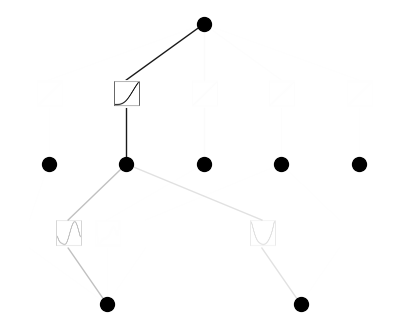

In [29]:
model(x)
model.plot()

In [59]:
tofile(x, 'x.dat')
tofile(y, 'y.dat')

In [38]:
save_checkpoint('checkpoint2.dat', [2, 3, 1], 3, 5, [coefficients, torch.ones([1, 5, 8])])

63
47


In [14]:
def fromfile(filename):
    with open(filename, "rb") as f:
        dim = int.from_bytes(f.read(4), byteorder='little')
        shape = []
        size = 1
        for _ in range(dim):
            shape.append(int.from_bytes(f.read(4), byteorder='little'))
            size *= shape[-1]
        stride = []
        for _ in range(dim):
            stride.append(int.from_bytes(f.read(4), byteorder='little'))
        buf = f.read(size * 4)
        arr = np.frombuffer(buf, dtype=np.float32).reshape(shape)
        return torch.tensor(arr)

In [109]:
b1 = b_splines(grid, x, 3)
b2 = fromfile("bases.bin")
(b1 - b2).abs().max()

tensor(0., grad_fn=<MaxBackward1>)

In [17]:
g1 = x.grad
g2 = fromfile("grad.bin")
(g1 - g2).abs().max()

tensor(1.4305e-06)

In [34]:
g2.shape

torch.Size([41, 2])

In [19]:
g1.sum(dim=0)

tensor([-0.1235, -0.0217])